# Learning GAN and WGAN for a synthetic 2-dimensional dataset

<br/><br/>
<a target="_blank" href="https://colab.research.google.com/github/generativemodelingmva/generativemodelingmva.github.io/blob/main/tp2425/tp3_generative_networks.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<br/><br/>

This practical session contains
- "QUESTION" fields in the text
- blocks of code that you should complete at every region marked with ### ... ###

We advise you to open the notebooks on Google Colab.

### Imports

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(device)

cpu


### Target Measure

In the following cell, we define the discrete target measure $\nu$ that will serve as dataset for this practical session.

The variable `xgrid` contains a grid of points that will be useful below to display the discriminators along training.

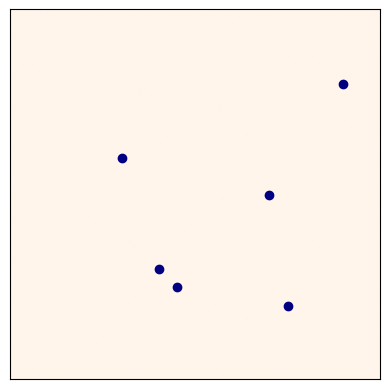

In [7]:
d = 2   # dimension of the data points
n = 6   # number of data points

y = torch.zeros((n,d), device=device)
y[0, 0] = 0.9
y[0, 1] = 0.2

y[1, 0] = 0.75
y[1, 1] = 0.8

y[2, 0] = 0.3
y[2, 1] = 0.4

y[3, 0] = 0.4
y[3, 1] = 0.7

y[4, 0] = 0.45
y[4, 1] = 0.75

y[5, 0] = 0.7
y[5, 1] = 0.5

nu = torch.ones(n, device=device)/n  # equal masses (nu is the empirical measure of the data)

# generate grid for plotting purpose
nr,nc = 256,256
extent = ((-0.5/nc, 1-0.5/nc, 1-0.5/nr, -0.5/nr))
xs = torch.linspace(0, 1, steps=nr)
ys = torch.linspace(0, 1, steps=nc)
xm, ym = torch.meshgrid(xs, ys, indexing='ij')
xm = xm.T
ym = ym.T
xgrid = torch.cat((xm.reshape(nr*nc,1),ym.reshape(nr*nc,1)),1).to(device)

# Plot data points
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

## Define Generator architecture

QUESTION: Examine the layers and parameters of the following generative network.

In [8]:
class Generator(torch.nn.Module):

    def __init__(self, n_in, n_out, n_hid=10, nlayers=3, device=torch.device("cpu")):
        super(Generator, self).__init__()

        self.n_in = n_in
        self.n_out = n_out
        self.n_hid = n_hid
        self.nlayers = nlayers
        self.hidden = nn.ModuleList()

        for n in range(nlayers):
            n_in_t = n_in if n==0 else n_hid
            self.hidden.append(nn.Sequential(
            nn.Linear(n_in_t, n_hid),
            nn.ELU(1)
        ).to(device))

        self.out = nn.Sequential(
            nn.Linear(n_hid, n_out),
            nn.Sigmoid()
        ).to(device)

        self.apply(self._init_weights)


    def forward(self, x):
        for n in range(self.nlayers):
            x = self.hidden[n](x)
        x = self.out(x)
        return x


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight, 1.0)
            if module.bias is not None:
                module.bias.data.zero_()


QUESTION: Plot one initial configuration of the generator (draw a batch of generated points)

In [9]:
torch.manual_seed(0)  # initialize random seed for reproducibility

n_in = 10    # dimension of the input noise
b = 100      # batch size

# Initialize generator
G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)

# Draw a batch x of generated points
#    Input noise z : standard normal with shape (b, n_in)

### ... ###

print(x.shape)

xd = x.detach()
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

NameError: name 'x' is not defined

<br/><br/><br/><br/>

# Exercise 1: WGAN Learning

## Discriminator Architecture

QUESTION: Examine the layers and parameters of the following discriminative network.

In [ ]:
class DWGAN(nn.Module):
  def __init__(self, n_in, n_hid=10):
    super(DWGAN, self).__init__()

    self.n_hid = n_hid
    self.n_in = n_in

    self.fc1 = nn.Linear(n_in, n_hid)
    self.fc2 = nn.Linear(n_hid, n_hid)
    self.fc3 = nn.Linear(n_hid, 1)

  def forward(self, x):
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc1(x))
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc2(y))
    y = self.fc3(y)
    return y

## Weight clipping

QUESTION: For a fixed generator, train the discriminator with WGAN loss and weight clipping.

Try changing the clip_value. What do you observe?

In [ ]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# fix one generator
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD=1000

clip_value = .1

D = DWGAN(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

iter_display = 100  # display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []

for iter in range(0,niterD):

    ### UPDATE OF D ###
    ### ... (optim of D) ... ###
    ### ... (weight clipping step) ... ###

    ### SAVE LOSS ###
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if(iter%iter_display == 0):
        print('[%d/%d], %f' % (iter, niterD, Dlosst))
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

plt.plot(Dlosses)

QUESTION: Now, train both the generator and discriminator with the WGAN loss and weight clipping.

In [ ]:
lr = 0.002   # learning rate for generator

## parameters for training
n_epochs = 100
niterD=1000
niterG=10

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generator and discriminator
### ... ###

optimG = optim.Adam(G.parameters(), lr=lr)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))


Glosses = []
Dlosses = []

clip_value = .1
iter_display = 10

# Main loop
for epoch in range(1,n_epochs):

    ############################
    ### Train discriminator (niterD iterations)
    ############################
    for iter in range(0,niterD):
        ### ... ###

    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
        ### ... ###


    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
      % (epoch, n_epochs, Dloss.item(), Gloss.item()))
    Glosses.append(Gloss.item())
    Dlosses.append(Dloss.item())

    if(epoch % iter_display == 0):
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()


### Plot the evolution of the discriminator and generator losses ###

plt.figure(dpi=100)
plt.plot(Dlosses,label='D')
plt.plot(Glosses,label='G')
plt.title('Loss evolution')
plt.legend()
plt.show()

# Save final generator for later use
wganwc = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wganwc.load_state_dict(G.state_dict())

## Estimate the Lipschitz constant of the discriminator

QUESTION: Implement a function computing an estimation of the Lipschitz constant of $D$ on points that are interpolated between $x$ and $y$.

Use this function to examine the Lipschitz constant of the final discriminator obtained with WGAN-WC.

In [ ]:
def lipconstant(D,x,y):
    # Calculate interpolation
    b = x.shape[0]
    n = y.shape[0]
    alpha = torch.rand((b,n,1),device=device)
    interp = (alpha * y[None,:,:] + (1 - alpha) * x[:,None,:]).flatten(end_dim=1)
    interp.requires_grad_()

    # Calculate discriminator on interpolated examples
    Di = ### ... ###

    # Calculate gradients of probabilities with respect to examples
    gradients = ### ... ###

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = ### ... ###

    # Return gradient penalty
    return ### ... ###

#### (lip constant of the current D) ###

## Gradient Penalty

QUESTION: Implement a function computing the gradient penalty of $D$ on points that are interpolated between $x$ and $y$.

In [ ]:
def gradient_penalty(D,x,y):
    # Calculate interpolation
    b = x.shape[0]
    n = y.shape[0]
    alpha = torch.rand((b,n,1),device=device)
    interp = (alpha * y[None,:,:] + (1 - alpha) * x[:,None,:]).flatten(end_dim=1)
    interp.requires_grad_()

    #### ... ###

    # Return gradient penalty
    #### ... ###



## Train the WGAN-GP discriminator for a fixed generator

QUESTION: Complete the following code at the blocks ###...###.

Adjust the weight of the gradient penalty (parameter `gpw`) to get a Lipschitz constant $\leq 1$.

How would you judge the resulting discriminator?

In [ ]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# Reinitialize generators and discriminators
#### ... ###

optimG = optim.Adam(G.parameters(), lr=lr)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
gpw = 1
niterD=1000

iter_display = 100  # display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []

for iter in range(0,niterD):

    #### ... ###
    # (adapt the loop written for WGAN-WC)

In [ ]:
print('Final estimated Lipschitz constant = ',lipconstant(D,x,y).item())

plt.figure(dpi=100)
plt.plot(Dlosses)
plt.title('Discriminator loss')
plt.show()

## Train both the Generator and Discriminator

QUESTION: Learn both generator and discriminator with the gradient penalty term

In [ ]:
lr = 0.002   # learning rate for generator

## parameters for training
n_epochs = 100
niterD=1000
niterG=10

lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
gpw = 0.1
niterD=100

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = DWGAN(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))


Glosses = []
Dlosses = []

iter_display = 5

#### ... ###
# (adapt the loop written for WGAN-WC)


# Save final generator for later use
wgan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wgan.load_state_dict(G.state_dict())

<br/><br/><br/><br/>

# Exercise 2: Learn a GAN

## Define Discriminator Architecture

QUESTION: What do you have to change to get a discriminator adapted for GAN training?

In [ ]:
class DGAN(nn.Module):
  def __init__(self, n_in, n_hid=10):
    super(DGAN, self).__init__()

    self.n_hid = n_hid
    self.n_in = n_in

    self.fc1 = nn.Linear(n_in, n_hid)
    self.fc2 = nn.Linear(n_hid, n_hid)
    self.fc3 = nn.Linear(n_hid, 1)

  def forward(self, x):
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc1(x))
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc2(y))
    y = nn.Sigmoid()(self.fc3(y))
    return y

## Train the discriminator for a fixed generator

QUESTION: Complete the following code at the blocks ###...###

In [ ]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD=1000

D = DGAN(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

iter_display = 100  # display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []

for iter in range(0,niterD):

    ### UPDATE OF D ###
    optimD.zero_grad()
    ### ... ###
    Dloss = ### ... ###
    Dloss.backward()
    optimD.step()

    ### SAVE LOSS ###
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if(iter%iter_display == 0):
        print('[%d/%d], %f' % (iter, niterD, Dlosst))
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()


In [ ]:
### Plot the evolution of the discriminator loss ###

plt.figure(dpi=100)
plt.plot(Dlosses)
plt.title('Discriminator loss')
plt.show()

## Train both the Generator and Discriminator

In [ ]:
lr = 0.002   # learning rate for generator

## parameters for training
n_epochs = 100
niterD=1000
niterG=10

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
### ... ###

Glosses = []
Dlosses = []

iter_display = 10

# Main loop
for epoch in range(n_epochs):

    ############################
    ### Train discriminator (niterD iterations)
    ############################
    for iter in range(0,niterD):
        ### ... ###

    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
        ### ... ###

    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
      % (epoch, n_epochs, Dloss.item(), Gloss.item()))
    Glosses.append(Gloss.item())
    Dlosses.append(-Dloss.item())


    if(epoch % iter_display == 0):
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, 1, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

# Save final generator for later use
gan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
gan.load_state_dict(G.state_dict())

In [ ]:
### Plot the evolution of the discriminator and generator losses ###

plt.figure(dpi=100)
plt.plot(Dlosses,label='D')
plt.plot(Glosses,label='G')
plt.title('Loss evolution')
plt.legend()
plt.show()

## Train the generator only

QUESTION: For a fixed discriminator, optimize only the generator only. Can you explain what is happening then?

In [ ]:
### ... ###

<br/><br/><br/><br/>